모듈 호출

In [68]:
import numpy as np
import pandas as pd
from fbprophet import Prophet
import matplotlib.pyplot as plt
%matplotlib inline

데이터 호출

In [69]:
record = pd.read_csv('record_output_new.csv',encoding='CP949')
salay= pd.read_csv('salary_output_new.csv',encoding='CP949')
schedule = pd.read_csv('schedule_output_new.csv',encoding='CP949')
RSB = pd.read_csv(r'C:\Users\ahn92\Documents\dev\Sources\20_Project\01_PJ_Dacon\data\Regular_Season_Batter.csv')
RSB_DBD = pd.read_csv(r'C:\Users\ahn92\Documents\dev\Sources\20_Project\01_PJ_Dacon\data\Regular_Season_Batter_Day_by_Day.csv')

생년월일 yyy-mm-dd 형식으로 변경

In [70]:
RSB['year_born'] = RSB['year_born'].map(lambda x: x.replace('년 ','-').replace('월 ','-').replace('일',''))

dataframe 칼럼 순서 변경

In [71]:
record = record[['batter_name', 'g', 'position', 'team', 'year','2타', '3타', 'HR', 'OPS', 'WAR', 'WOBA', 'WPA', 'WRC+', 'age',
        'year_born', '고4', '도루',
       '도실', '득점', '루타', '병살', '볼넷', '사구', '삼진', '안타', '장타', '출루', '타석', '타수',
       '타율', '타점', '희비', '희타']]

경기 날짜 datetime형식으로 변경 후 year와 date컬럼 삭제

In [72]:
schedule['ymd'] = pd.to_datetime(schedule['year'].map(lambda x : str(x))+'-'+schedule['date'])

In [73]:
schedule = schedule.drop(columns=['year','date'])

컬럼 순서변경

In [74]:
schedule =schedule[[ 'batter_name', 'year_born', 'cur_team', 'team', 'ymd','opposition', 
                  'result', 'batter_no', 'position', 'is_starter', 'AB',
                  'R', 'H', '2B', '3B', 'HR', 'TB', 'RBI', 'SB', 'CS', 'BB', 'HBP', 'IBB',
                  'K', 'GDP', 'SH', 'SF', 'avg2', 'OBP', 'SLG', 'OPS', '투구', 'avLi',
                  'RE24', 'WPA']]

경기장소 정보 홈경기/원정경기 컬럼 생성

In [75]:
schedule['is_away'] = schedule['opposition'].map(lambda x : 1 if x[0]=='@' else 0)
schedule['opposition'] = schedule['opposition'].map(lambda x: x[1:] if x[0]=='@' else x)

일간 OPS를 계산해서 변수 추가

In [76]:
def OBP_day(x):
    try:
        out = (x['H']+ x['BB']+x['HBP']) / (x['BB'] + x['HBP'] +x['AB'] + x['SF'] )
    except:
        out = np.nan
    return out
def SLG_day(x):
    try:
        return (x['H']-x['2B']-x['3B']-x['HR'] + 2*x['2B'] + 3*x['3B'] + 4*x['2B'])/x['AB']
    except:
        return(np.nan)
#[단타 + (2*2루타) + (3*3루타) + (4*홈런] / 타수

schedule['OPS_d'] = schedule.apply(lambda x: SLG_day(x),axis=1) + schedule.apply(lambda x: OBP_day(x),axis=1)

해당선수의 해당년도 해당 변수 시계열 그래프를 그려주는 함수 생성

In [77]:
def tsplot0(day,name,year,col):
    x = day[(day['ymd'].map(lambda x: x.year) == year) & ((day['batter_name']==name))]
    ts = pd.Series(x[col])
    ts.index = x['ymd']
    ts.plot()

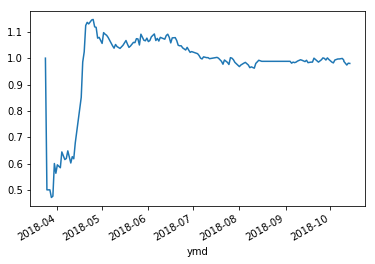

In [78]:
tsplot0(schedule,'이대호',2018,'OPS')

팀 정보 확인

In [79]:
schedule['cur_team'].unique()

array(['LG', '한화', 'NC', '삼성', 'KT', 'SK', '넥센', '롯데', '두산', 'KIA', 'kt',
       '현대'], dtype=object)

kt팀을 모두 대문자 KT로 통일

In [80]:
schedule['cur_team'] = schedule['cur_team'].map(lambda x : 'KT' if x=='kt' else x)

시계열 예측을 해주는 함수 생성

In [81]:
def fbforecast(batter_name,year_born=None,valid=False):
    #valid = True
    #batter_name = '이대호'
    #year_born = '1982-06-21'
    if year_born!=None:
        player = schedule[(schedule['batter_name']==batter_name) & (schedule['year_born']==year_born)]
    else:
        player = schedule[schedule['batter_name']==batter_name]        
    target = 'OPS_d'
    ts = player[['ymd',target]].reset_index().drop(columns = 'index')

    pts = pd.DataFrame()
    pts['y'] = ts[target]
    pts['ds'] = pd.to_datetime(ts['ymd'])
    #pts['is_away'] = ts['is_away']

    my_model = Prophet(interval_width = 0.8)
    #my_model.add_regressor('is_away')
    
    if valid:
        my_model.fit(pts)
        schedule19Path = r'C:\Users\ahn92\Documents\dev\Sources\20_Project\01_PJ_Dacon\Schedule_2019'
        cur_team = player.iloc[0]['cur_team']
        team_schedule = pd.read_csv(schedule19Path+'\\'+cur_team+'.csv', encoding='CP949',engine='python')['date'].map(lambda x : '2019-' + x[:5].replace('.','-'))
    else:
        my_model.fit(pts[pts['ds']<'2018-01-01'])
        team_schedule = player[(player['ymd']<'2018-07-14') & (player['ymd']>'2018-01-01')]['ymd']
        #team_schedule_ia = player[(player['ymd']<'2018-07-14') & (player['ymd']>'2018-01-01')]['is_away']
        
    future_dates = pd.DataFrame({'ds' :team_schedule})
    forecast = my_model.predict(future_dates)

    out = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][forecast['yhat']>0].mean()['yhat']
    return (forecast,out)

In [93]:
fbforecast('박병호')[1]

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\ProgramData\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


1.6277320786265712

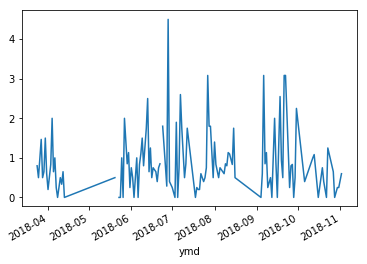

In [94]:
tsplot0(schedule,'박병호',2018,'OPS_d')

시계열 예측값을 그려주는 함수 생성

In [86]:
def tsplot(x):
    ts = pd.Series(x['yhat'])
    ts.index = x['ds']
    ts.plot()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\ProgramData\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


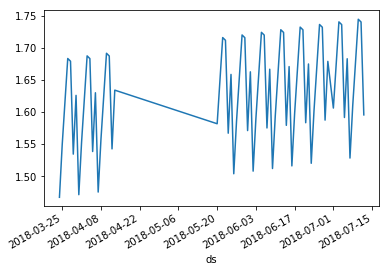

In [95]:
tsplot(fbforecast('박병호')[0])

2018년도를 validation으로 선정하여 CV를 위한 정답지(2018년 상반기까지의 OPS) 생성

In [97]:
vaild_ops = schedule[(schedule['ymd'].map(lambda x : x.year)==2018) & (schedule['ymd']<'2018-07-14')].\
            groupby('batter_name').max()['ymd'].reset_index().merge(schedule, on=['batter_name','ymd'])[['batter_name','OPS']]

선수별 시계열 모형 선정

In [105]:
valid_out = []
err = []
for i,j in zip(RSB[RSB['year']==2018]['batter_name'],RSB[RSB['year']==2018]['year_born']):
    try:
        valid_out.append([i,j,fbforecast(i,j,valid=True)[1]])
    except:
        err.append([i,j])

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\ProgramData\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 7.0.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 18.0.
INFO:fbprophet:Disabling daily seasonalit

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 19.0.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 23.0.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
IN

선수이름 선수 생년월일 정보가 일치하지 않아 에러가 나는 선수명단

In [98]:
err

[['가르시아', '1985-04-12'],
 ['강민국', '1992-01-10'],
 ['강백호', '1999-07-29'],
 ['고명성', '1999-04-16'],
 ['김동욱', '1988-06-24'],
 ['김재현', '1991-08-30'],
 ['김종덕', '1993-05-12'],
 ['김철호', '1998-02-06'],
 ['김태진', '1995-10-07'],
 ['김형준', '1999-11-02'],
 ['배정대', '1995-06-12'],
 ['백민기', '1990-09-16'],
 ['백상원', '1988-01-02'],
 ['샌즈', '1987-09-28'],
 ['신범수', '1998-01-25'],
 ['윤수강', '1990-02-22'],
 ['이대수', '1981-08-21'],
 ['이대형', '1983-07-19'],
 ['이병휘', '1998-08-05'],
 ['이준수', '1988-06-17'],
 ['이흥련', '1989-05-16'],
 ['장승현', '1994-03-07'],
 ['장시윤', '1993-09-23'],
 ['장진혁', '1993-09-30'],
 ['전민재', '1999-06-30'],
 ['전병우', '1992-10-24'],
 ['정수빈', '1990-10-07'],
 ['정은원', '2000-01-17'],
 ['최원제', '1989-02-04'],
 ['한동희', '1999-06-01'],
 ['호잉', '1989-05-18'],
 ['홍창기', '1993-11-21']]

In [99]:
valid_forecast = pd.DataFrame(valid_out)
valid_forecast.columns = ['batter_name','year_born','ops_hat']

In [100]:
tmp = valid_forecast.merge(vaild_ops,on=['batter_name'])

val_df = tmp.merge(RSB[RSB['year']==2018][['batter_name','AB']] , on = 'batter_name')

bias를 줄여주기위해 예측 OPS을 일정 비율로 나눠줌

In [101]:
val_df['ops_hat'] = val_df['ops_hat']*(val_df['OPS']/val_df['ops_hat']).mean()

In [102]:
(val_df['OPS']/val_df['ops_hat']).mean()

0.9999999999999989

WRMSE 계산

In [103]:
tmp = val_df[-val_df['ops_hat'].isna()].apply(lambda x: (x['ops_hat']-x['OPS'])**2 * x['AB'] ,axis =1).sum() / val_df[-val_df['ops_hat'].isna()]['AB'].sum()
wrmse = tmp**(1/2)
print('wrmse = '+str(wrmse))

wrmse = 1.0611625151060442


In [104]:
val_df

,batter_name,year_born,ops_hat,OPS,AB
0,강경학,1992-08-11,0.544515,0.931,245
1,강구성,1993-06-09,0.509554,0.600,5
2,강민호,1985-08-18,0.893209,0.801,427
3,강상원,1997-05-05,2.180525,0.143,6
4,강승호,1994-02-09,0.877596,0.540,184
5,강진성,1993-10-19,NaN,0.581,68
6,강한울,1991-09-12,0.853907,0.611,193
7,고종욱,1989-01-11,1.009870,0.671,330
8,구자욱,1993-02-12,1.271897,0.801,478
9,국해성,1989-10-08,0.658508,0.887,24
